In [1]:
%%capture
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import utils

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
2.15.0
1 Physical GPUs, 1 Logical GPUs


In [4]:
#set the necessary seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import datasets

### Breast cancer dataset

In [5]:
train_pairs_breast, val_pairs_breast, test_pairs_breast = utils.split_dataset(utils.create_list())
print(f"Number of training pairs: {len(train_pairs_breast)}")
print(f"Number of val pairs: {len(val_pairs_breast)}")
print(f"Number of test_pairs pairs: {len(test_pairs_breast)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [6]:
train_dataset_breast = utils.create_dataset(train_pairs_breast, augment=True)
val_dataset_breast = utils.create_dataset(val_pairs_breast)
test_dataset_breast = utils.create_dataset(test_pairs_breast)

In [7]:
batch_size = 8

In [8]:
#batch the dataset and shuffle the training set

train_dataset_breast = train_dataset_breast.shuffle(buffer_size=len(train_pairs_breast)).batch(batch_size)
val_dataset_breast = val_dataset_breast.batch(batch_size)
test_dataset_breast = test_dataset_breast.batch(batch_size)

### Skin cancer dataset

In [4]:
train_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Training_Data", "ISIC-2017_Training_Part1_GroundTruth"), augment=True)
val_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Validation_Data", "ISIC-2017_Validation_Part1_GroundTruth"))
test_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Test_v2_Data", "ISIC-2017_Test_v2_Part1_GroundTruth"))

In [6]:
train_dataset_skin = train_dataset_skin.shuffle(buffer_size=2000).batch(batch_size)
val_dataset_skin = val_dataset_skin.batch(batch_size)
test_dataset_skin = test_dataset_skin.batch(batch_size)

### Brain cancer datatset

In [4]:
train_pairs_brain, val_pairs_brain, test_pairs_brain = utils.split_dataset(utils.create_list_brain())
print(f"Number of training pairs: {len(train_pairs_brain)}")
print(f"Number of val pairs: {len(val_pairs_brain)}")
print(f"Number of test_pairs pairs: {len(test_pairs_brain)}")

Number of training pairs: 1838
Number of val pairs: 613
Number of test_pairs pairs: 613


In [5]:
train_dataset_brain = utils.create_dataset(train_pairs_brain, augment=True)
val_dataset_brain = utils.create_dataset(val_pairs_brain)
test_dataset_brain = utils.create_dataset(test_pairs_brain)

In [8]:
train_dataset_brain = train_dataset_brain.shuffle(buffer_size=len(train_pairs_brain)).batch(batch_size)
val_dataset_brain = val_dataset_brain.batch(batch_size)
test_dataset_brain = test_dataset_brain.batch(batch_size)

## Architecture definition

In [8]:
from keras import layers, Model
#function for encoder convolutional layers
def convolutional_layer(input, num_filters, kernel_size=(3, 3), initializer="he_normal"):

    #first convolution
    x = layers.Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same', kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    #second convolution
    x = layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [36]:
def basic_unet(input_size, num_filters=16):
    inputs = tf.keras.Input(shape=input_size)

    #encoder block
    first_conv = convolutional_layer(inputs, num_filters)
    first_layer = layers.MaxPool2D(pool_size=(2, 2))(first_conv)
    first_layer = layers.Dropout(0.1)(first_layer)

    second_conv = convolutional_layer(first_layer, num_filters * 2)
    second_layer = layers.MaxPool2D(pool_size=(2, 2))(second_conv)
    second_layer = layers.Dropout(0.1)(second_layer)

    third_conv = convolutional_layer(second_layer, num_filters * 4)
    third_layer = layers.MaxPool2D(pool_size=(2, 2))(third_conv)
    third_layer = layers.Dropout(0.1)(third_layer)

    fourth_conv = convolutional_layer(third_layer, num_filters * 8)
    fourth_layer = layers.MaxPool2D(pool_size=(2, 2))(fourth_conv)
    fourth_layer = layers.Dropout(0.1)(fourth_layer)

    fifth_conv = convolutional_layer(fourth_layer, num_filters * 16)

    #decoder block
    first_deconv = layers.Conv2DTranspose(num_filters * 8, kernel_size=(3, 3), strides=(2, 2), padding='same')(fifth_conv)
    sixth_layer = layers.concatenate([first_deconv, fourth_conv])
    sixth_layer = layers.Dropout(0.2)(sixth_layer)
    sixth_conv = convolutional_layer(sixth_layer, num_filters * 8)

    second_deconv = layers.Conv2DTranspose(num_filters * 4, kernel_size=(3, 3), strides=(2, 2), padding='same')(sixth_conv)
    seventh_layer = layers.concatenate([second_deconv, third_conv])
    seventh_layer = layers.Dropout(0.2)(seventh_layer)
    seventh_conv = convolutional_layer(seventh_layer, num_filters * 4)

    third_deconv = layers.Conv2DTranspose(num_filters * 2, kernel_size=(3, 3), strides=(2, 2), padding='same')(seventh_conv)
    eighth_layer = layers.concatenate([third_deconv, second_conv])
    eighth_layer = layers.Dropout(0.2)(eighth_layer)
    eighth_conv = convolutional_layer(eighth_layer, num_filters * 2)

    fourth_deconv = layers.Conv2DTranspose(num_filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(eighth_conv)
    ninth_layer = layers.concatenate([fourth_deconv, first_conv])
    ninth_layer = layers.Dropout(0.2)(ninth_layer)
    ninth_conv = convolutional_layer(ninth_layer, num_filters)

    #output layer
    output = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(ninth_conv)

    unet = Model(inputs=inputs, outputs=output)

    return unet

In [9]:
tf.keras.utils.get_custom_objects()["dice_loss"] = utils.dice_loss
tf.keras.utils.get_custom_objects()["bce_dice_loss"] = utils.bce_dice_loss
tf.keras.utils.get_custom_objects()["tversky_loss"] = utils.tversky_loss
tf.keras.utils.get_custom_objects()["dice_coefficient"] = utils.dice_coefficient
tf.keras.utils.get_custom_objects()["iou"] = utils.iou

In [37]:
# u-net with tversky loss

basic_unet = basic_unet(input_size=(256, 256, 3))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
lr_adapter = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coefficient", mode = "max", factor=0.1, patience=7, min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_dice_coefficient", mode= "max", patience=13, restore_best_weights=True)

basic_unet.compile(optimizer=optimizer, loss=utils.tversky_loss, metrics=[utils.dice_coefficient, utils.iou, "accuracy"])

In [33]:
basic_unet.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_95 (Conv2D)          (None, 256, 256, 32)         896       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_90 (Ba  (None, 256, 256, 32)         128       ['conv2d_95[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_90 (Activation)  (None, 256, 256, 32)         0         ['batch_normalization_90

In [18]:
#non cambiare!!!

best_history = basic_unet.fit(train_dataset_breast, epochs=100, validation_data=val_dataset_breast, callbacks=[lr_adapter, early_stopping])

Epoch 1/100


I0000 00:00:1738608796.306388      83 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 [==============================] - 40s 305ms/step - loss: 0.6572 - dice_coefficient: 0.2614 - iou: 0.1527 - accuracy: 0.6014 - val_loss: 0.7600 - val_dice_coefficient: 0.1535 - val_iou: 0.0845 - val_accuracy: 0.1269 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 8s 132ms/step - loss: 0.5714 - dice_coefficient: 0.3339 - iou: 0.2037 - accuracy: 0.6960 - val_loss: 0.7359 - val_dice_coefficient: 0.1712 - val_iou: 0.0953 - val_accuracy: 0.2536 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 8s 133ms/step - loss: 0.5370 - dice_coefficient: 0.3719 - iou: 0.2326 - accuracy: 0.7474 - val_loss: 0.6807 - val_dice_coefficient: 0.2162 - val_iou: 0.1240 - val_accuracy: 0.5160 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 8s 132ms/step - loss: 0.5210 - dice_coefficient: 0.3948 - iou: 0.2512 - accuracy: 0.7670 - val_loss: 0.7091 - val_dice_coefficient: 0.1914 - val_iou: 0.1081 - val_accuracy: 0.3531 - lr: 0.0010
Epoch 5/100
49/49 [========

In [17]:
history_breast = basic_unet.fit(train_dataset_breast, epochs=100, validation_data=val_dataset_breast, callbacks=[lr_adapter, early_stopping])

Epoch 1/100
49/49 [==============================] - 19s 151ms/step - loss: 0.6572 - dice_coefficient: 0.2573 - iou: 0.1504 - accuracy: 0.4820 - val_loss: 0.7632 - val_dice_coefficient: 0.1512 - val_iou: 0.0831 - val_accuracy: 0.1078 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 8s 134ms/step - loss: 0.5895 - dice_coefficient: 0.3135 - iou: 0.1887 - accuracy: 0.6691 - val_loss: 0.7549 - val_dice_coefficient: 0.1571 - val_iou: 0.0868 - val_accuracy: 0.1531 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 8s 140ms/step - loss: 0.5598 - dice_coefficient: 0.3435 - iou: 0.2109 - accuracy: 0.7012 - val_loss: 0.7591 - val_dice_coefficient: 0.1541 - val_iou: 0.0849 - val_accuracy: 0.1277 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 9s 149ms/step - loss: 0.5274 - dice_coefficient: 0.3818 - iou: 0.2397 - accuracy: 0.7650 - val_loss: 0.6328 - val_dice_coefficient: 0.2544 - val_iou: 0.1494 - val_accuracy: 0.6078 - lr: 0.0010
Epoch 5/100
49/

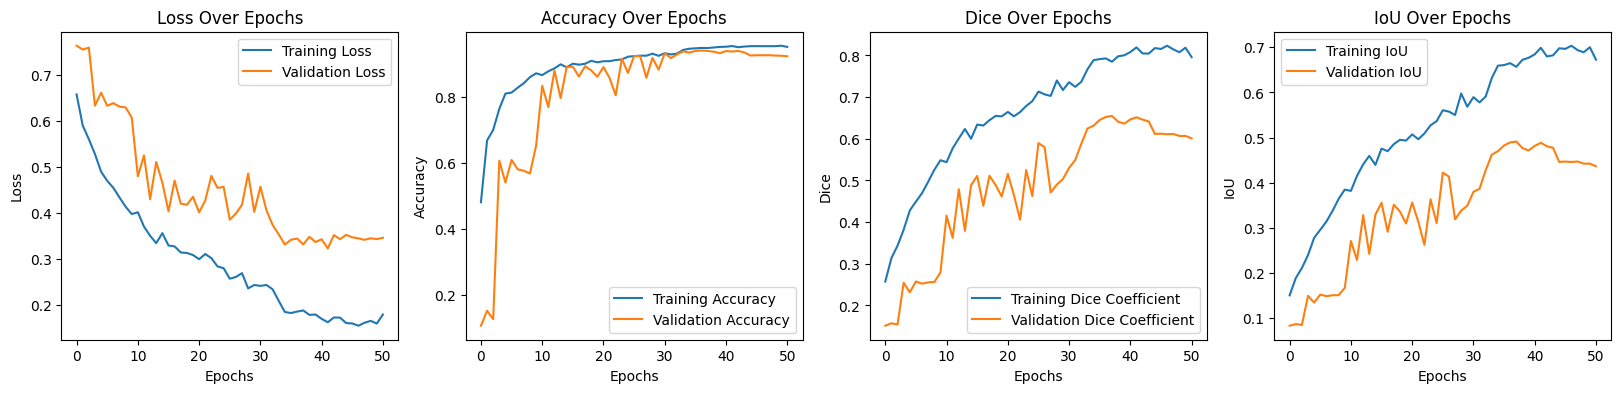

In [18]:
history_dict = history_breast.history

#plot Loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

#plot accuracy
if 'accuracy' in history_dict:
    plt.subplot(1, 4, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

#plot dice
if 'dice_coefficient' in history_dict:
    plt.subplot(1, 4, 3)
    plt.plot(history_dict['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history_dict['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.title('Dice Over Epochs')
    plt.legend()

#plot iou
if 'iou' in history_dict:
    plt.subplot(1, 4, 4)
    plt.plot(history_dict['iou'], label='Training IoU')
    plt.plot(history_dict['val_iou'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Over Epochs')
    plt.legend()

plt.show()

In [26]:
basic_unet.save("basic_unet_best_breast.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
best_unet_breast = tf.keras.models.load_model("basic_unet_best_breast.h5")

In [11]:
test_loss, test_dice, test_iou, test_accuracy = best_unet_breast.evaluate(test_dataset_breast)

17/17 [==============================] - 7s 107ms/step - loss: 0.4101 - dice_coefficient: 0.5923 - iou: 0.4357 - accuracy: 0.9294


1/1 [==============================] - 0s 446ms/step


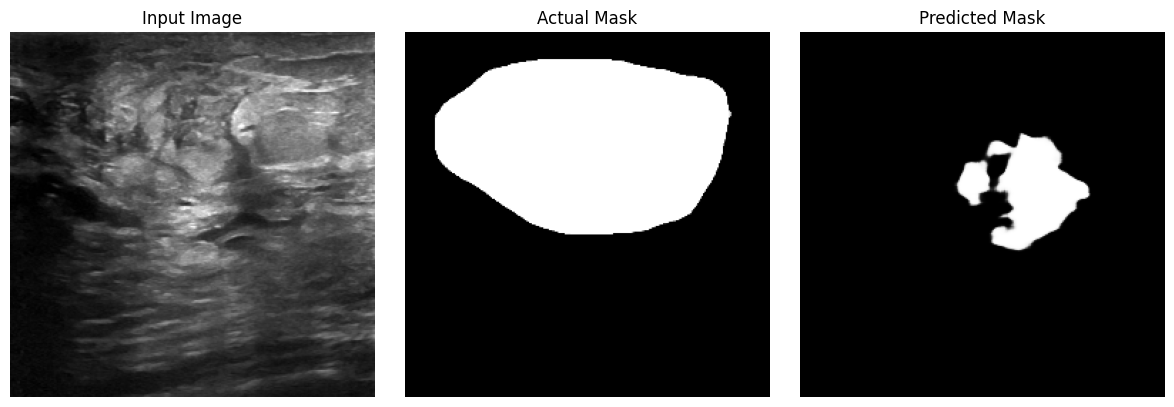

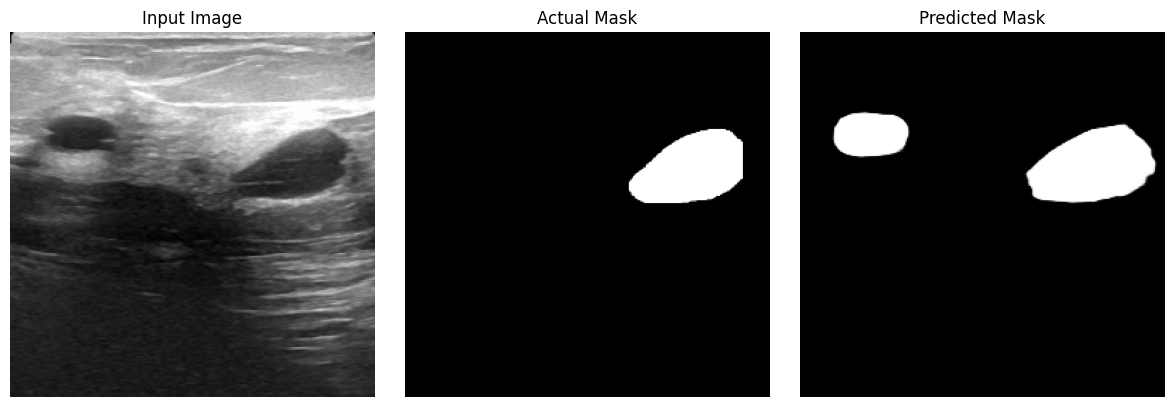

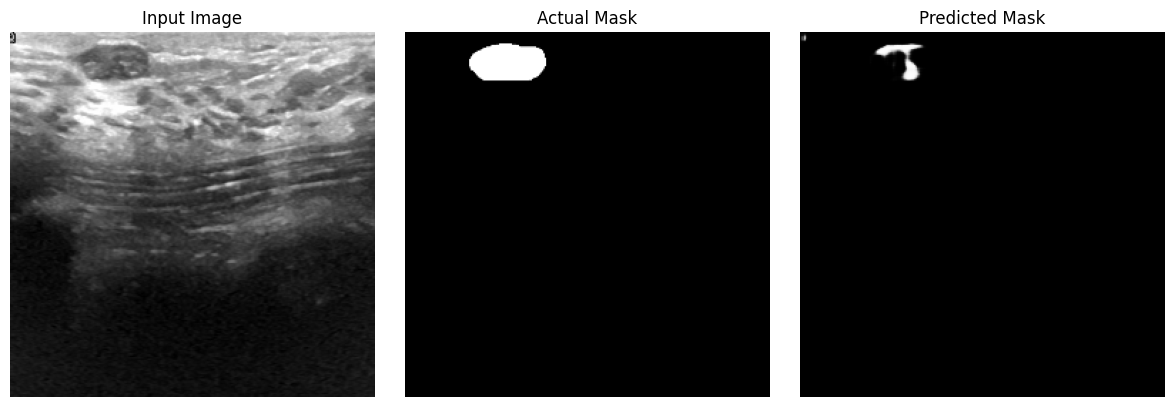

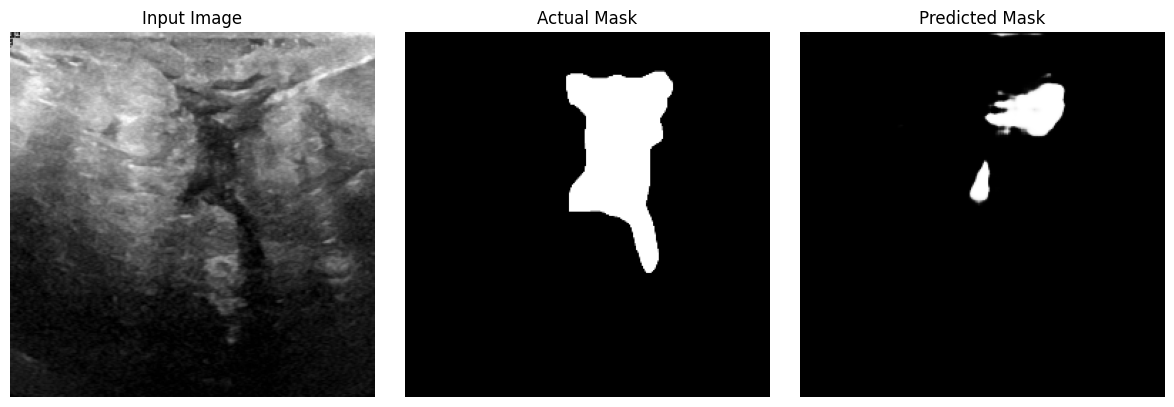

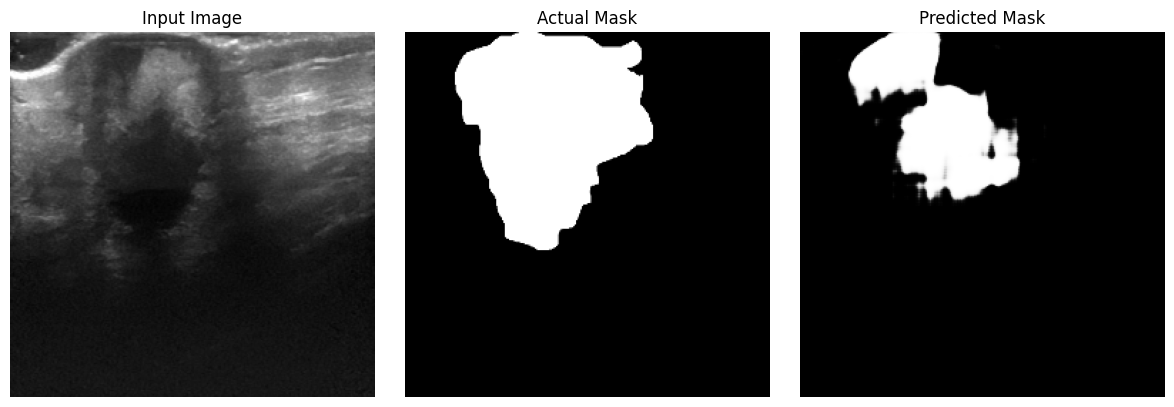

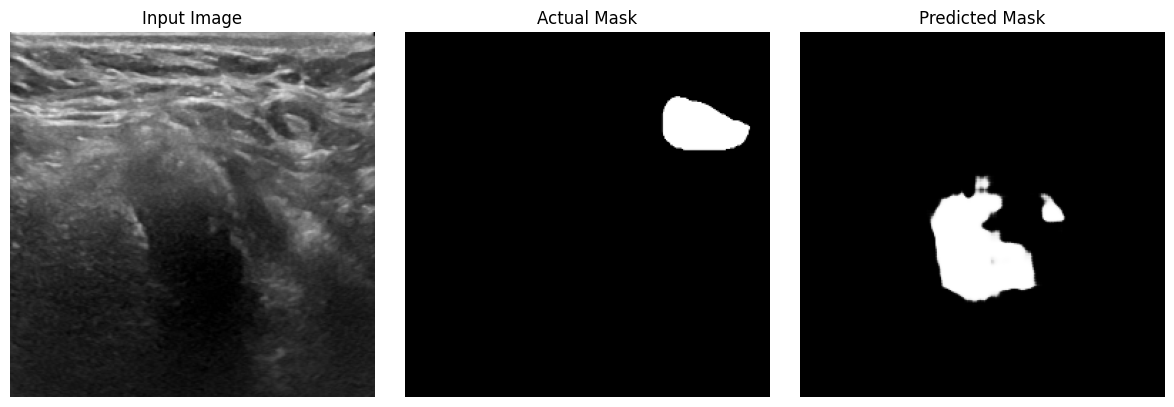

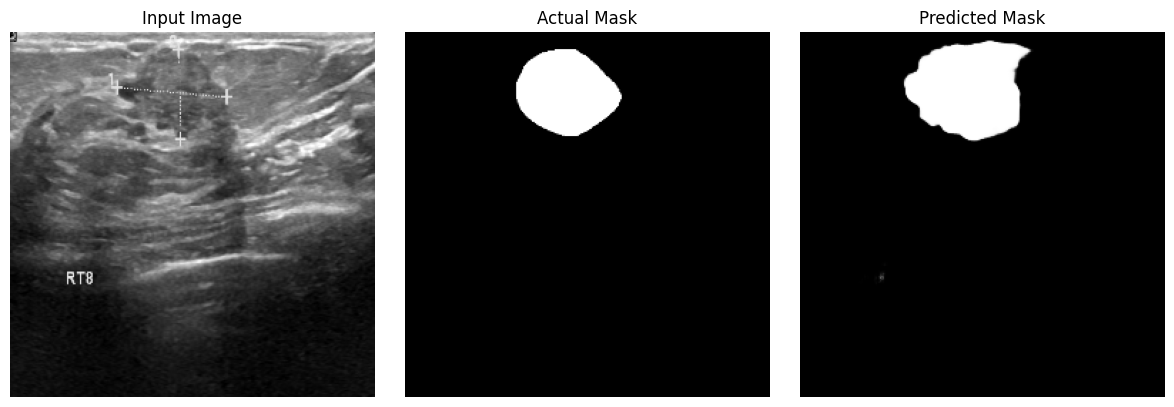

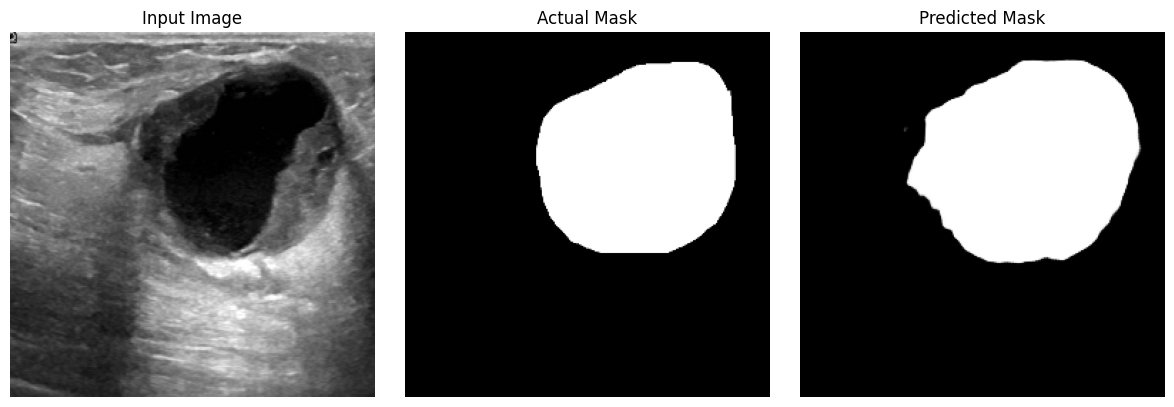

In [12]:
for i, (image, mask) in enumerate(test_dataset_breast.take(1)):
    predicted_mask = best_unet_breast.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

### Fit on the skin cancer dataset

In [18]:
#don't change!!!

best_history_skin = basic_unet.fit(train_dataset_skin, epochs=100, validation_data=val_dataset_skin, callbacks=[lr_adapter, early_stopping])

Epoch 1/100
250/250 [==============================] - 82s 132ms/step - loss: 0.9367 - dice_coefficient: 0.5237 - iou: 0.3640 - accuracy: 0.7279 - val_loss: 0.8709 - val_dice_coefficient: 0.2922 - val_iou: 0.1782 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 2/100
250/250 [==============================] - 59s 114ms/step - loss: 0.4534 - dice_coefficient: 0.6245 - iou: 0.4660 - accuracy: 0.8051 - val_loss: 0.5757 - val_dice_coefficient: 0.4634 - val_iou: 0.3250 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 3/100
250/250 [==============================] - 59s 112ms/step - loss: 0.3572 - dice_coefficient: 0.6956 - iou: 0.5433 - accuracy: 0.8455 - val_loss: 0.5247 - val_dice_coefficient: 0.5002 - val_iou: 0.3575 - val_accuracy: 0.7872 - lr: 0.0010
Epoch 4/100
250/250 [==============================] - 60s 112ms/step - loss: 0.3475 - dice_coefficient: 0.6962 - iou: 0.5457 - accuracy: 0.8403 - val_loss: 0.6974 - val_dice_coefficient: 0.3459 - val_iou: 0.2236 - val_accuracy: 0.6640 - lr: 0.0010
Epoc

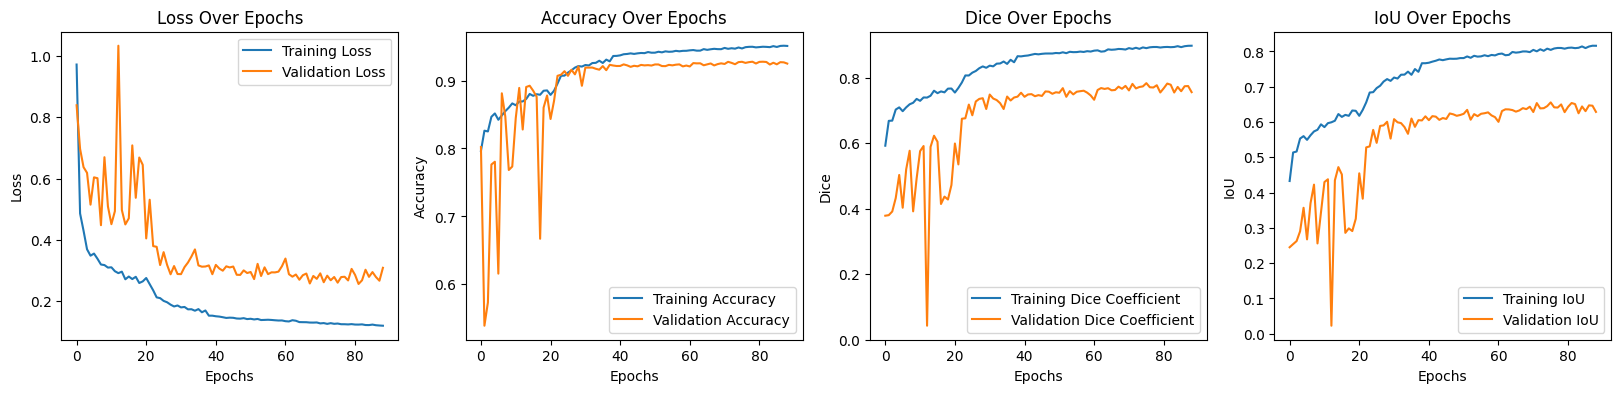

In [40]:
history_dict = best_history_skin.history

#plot Loss
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

#plot accuracy
if 'accuracy' in history_dict:
    plt.subplot(1, 4, 2)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()

#plot dice
if 'dice_coefficient' in history_dict:
    plt.subplot(1, 4, 3)
    plt.plot(history_dict['dice_coefficient'], label='Training Dice Coefficient')
    plt.plot(history_dict['val_dice_coefficient'], label='Validation Dice Coefficient')
    plt.xlabel('Epochs')
    plt.ylabel('Dice')
    plt.title('Dice Over Epochs')
    plt.legend()

#plot iou
if 'iou' in history_dict:
    plt.subplot(1, 4, 4)
    plt.plot(history_dict['iou'], label='Training IoU')
    plt.plot(history_dict['val_iou'], label='Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU Over Epochs')
    plt.legend()

plt.show()

In [20]:
basic_unet.save("basic_unet_best_skin.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
best_unet = tf.keras.models.load_model("basic_unet_best_skin.h5")

In [14]:
test_loss_skin, test_dice_skin, test_iou_skin, test_accuracy_skin = best_unet.evaluate(test_dataset_skin)

75/75 [==============================] - 29s 376ms/step - loss: 0.2109 - dice_coefficient: 0.8096 - iou: 0.6920 - accuracy: 0.9238


1/1 [==============================] - 0s 54ms/step


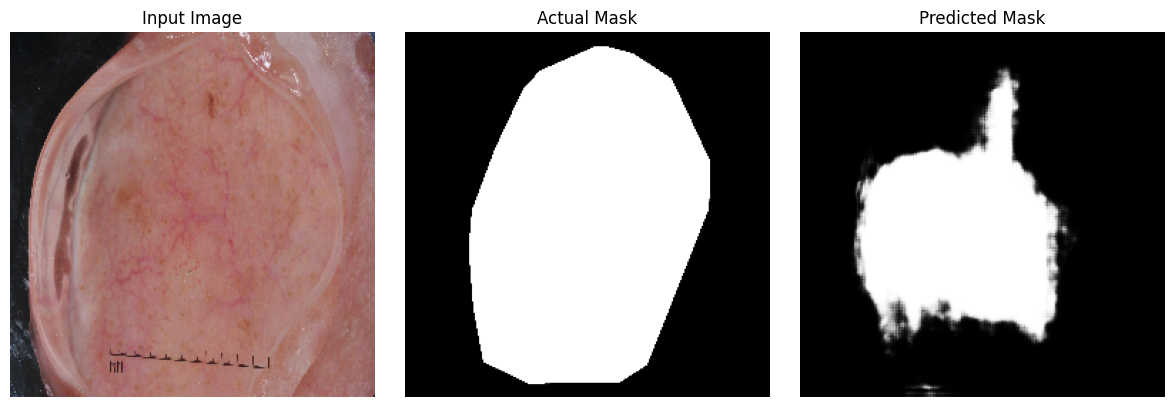

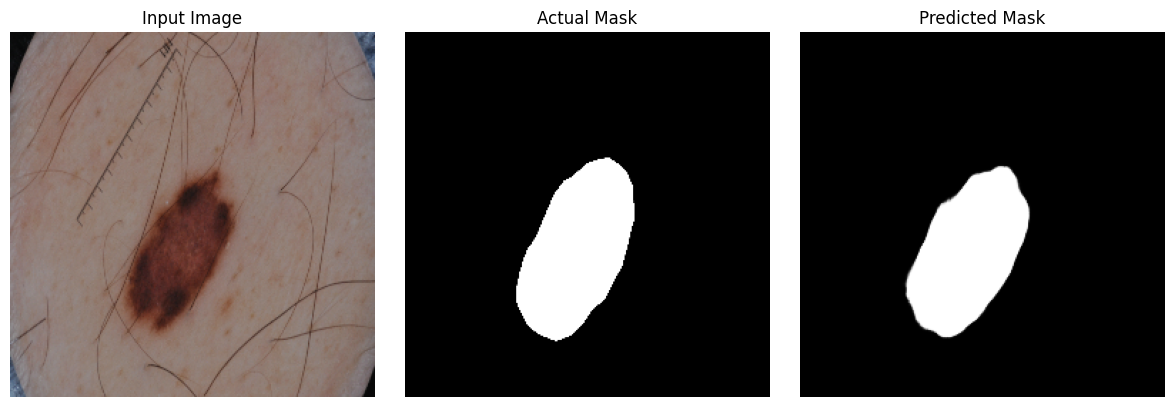

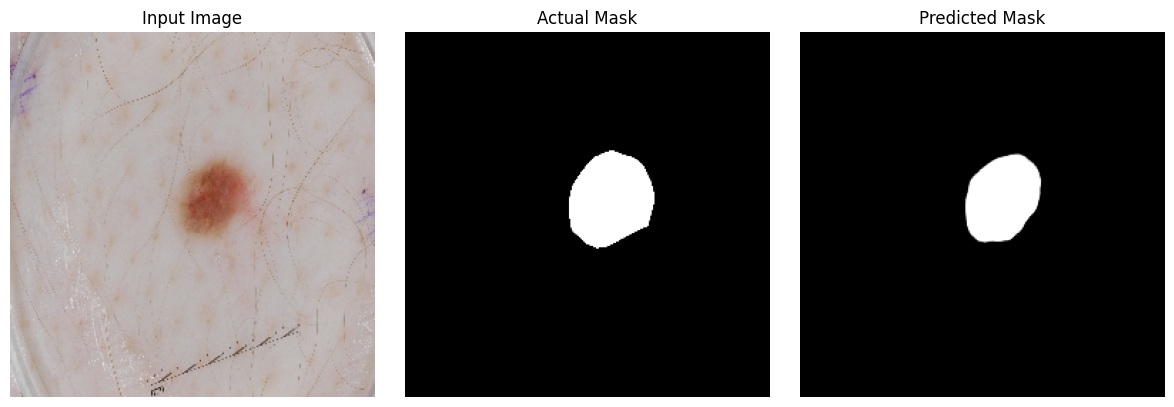

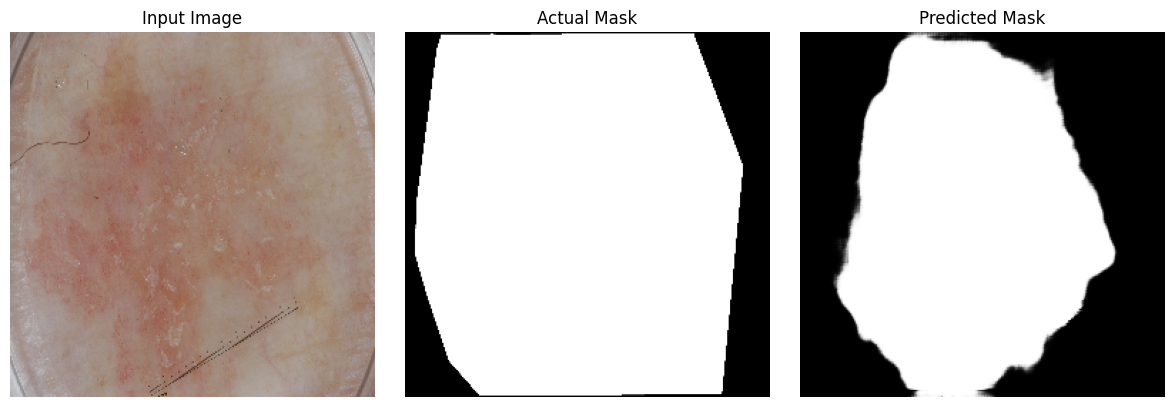

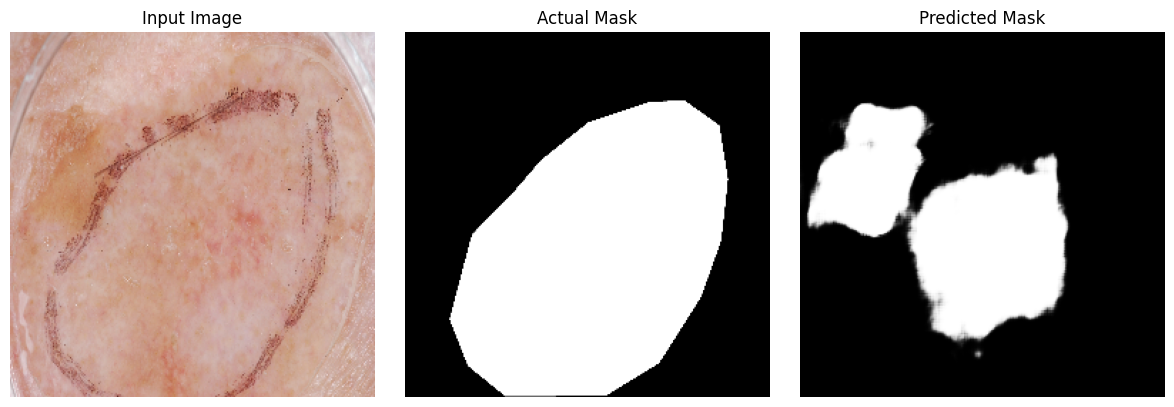

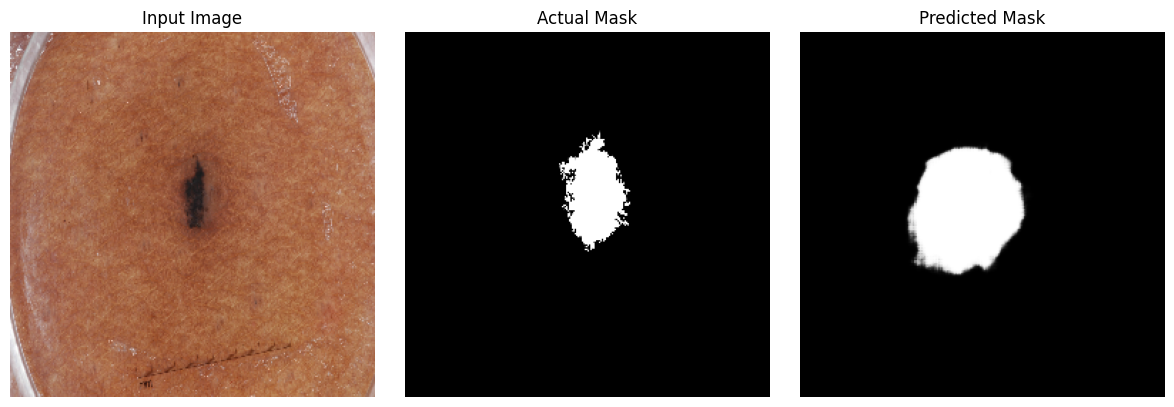

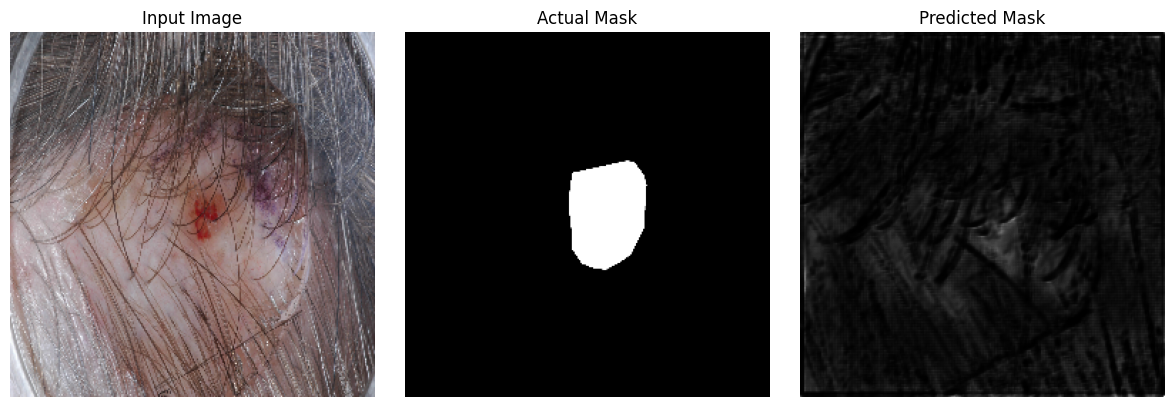

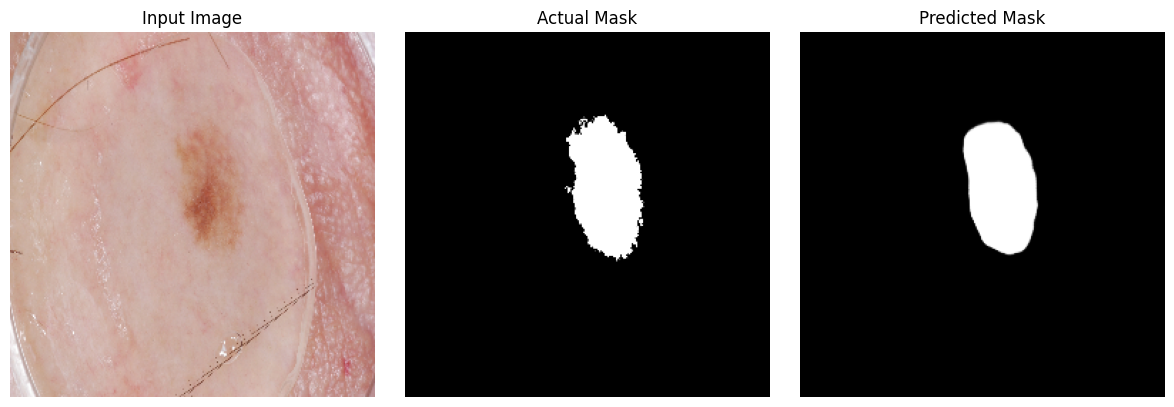

In [20]:
for i, (image, mask) in enumerate(test_dataset_skin.take(1)):
    predicted_mask = best_unet.predict(image)
    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

### Fit on the brain cancer dataset

In [38]:
history = basic_unet.fit(train_dataset_brain, validation_data=val_dataset_brain, epochs=100, callbacks=[lr_adapter, early_stopping])

Epoch 1/100
230/230 [==============================] - 50s 141ms/step - loss: 0.7917 - dice_coefficient: 0.1539 - iou: 0.0857 - accuracy: 0.8383 - val_loss: 0.9849 - val_dice_coefficient: 0.0094 - val_iou: 0.0047 - val_accuracy: 0.4622 - lr: 0.0010
Epoch 2/100
230/230 [==============================] - 42s 154ms/step - loss: 0.5749 - dice_coefficient: 0.3787 - iou: 0.2400 - accuracy: 0.9647 - val_loss: 0.8248 - val_dice_coefficient: 0.1231 - val_iou: 0.0662 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 3/100
230/230 [==============================] - 45s 168ms/step - loss: 0.4945 - dice_coefficient: 0.4590 - iou: 0.3044 - accuracy: 0.9698 - val_loss: 0.5245 - val_dice_coefficient: 0.4679 - val_iou: 0.3129 - val_accuracy: 0.9827 - lr: 0.0010
Epoch 4/100
230/230 [==============================] - 45s 166ms/step - loss: 0.4519 - dice_coefficient: 0.5078 - iou: 0.3478 - accuracy: 0.9737 - val_loss: 0.8005 - val_dice_coefficient: 0.1592 - val_iou: 0.0890 - val_accuracy: 0.9437 - lr: 0.0010
Epoc

In [39]:
test_loss, test_dice, test_iou, test_accuracy = basic_unet.evaluate(test_dataset_brain)

77/77 [==============================] - 3s 33ms/step - loss: 0.2591 - dice_coefficient: 0.7411 - iou: 0.5991 - accuracy: 0.9909


In [13]:
#non cambiare!!!

best_history = basic_unet.fit(train_dataset_brain, validation_data=val_dataset_brain, epochs=100, callbacks=[lr_adapter, early_stopping])

Epoch 1/100


I0000 00:00:1738612141.249776   17389 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


268/268 [==============================] - 70s 145ms/step - loss: 0.8271 - dice_coefficient: 0.1178 - iou: 0.0637 - accuracy: 0.7797 - val_loss: 0.9544 - val_dice_coefficient: 0.0287 - val_iou: 0.0146 - val_accuracy: 0.6104 - lr: 0.0010
Epoch 2/100
268/268 [==============================] - 48s 153ms/step - loss: 0.6084 - dice_coefficient: 0.3329 - iou: 0.2057 - accuracy: 0.9573 - val_loss: 0.9584 - val_dice_coefficient: 0.0423 - val_iou: 0.0231 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/100
268/268 [==============================] - 51s 161ms/step - loss: 0.5100 - dice_coefficient: 0.4442 - iou: 0.2917 - accuracy: 0.9697 - val_loss: 0.6852 - val_dice_coefficient: 0.3698 - val_iou: 0.2352 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 4/100
268/268 [==============================] - 52s 166ms/step - loss: 0.4536 - dice_coefficient: 0.5068 - iou: 0.3459 - accuracy: 0.9745 - val_loss: 0.4147 - val_dice_coefficient: 0.5361 - val_iou: 0.3720 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 5/100
268/

In [41]:
basic_unet.save("basic_unet_best_brain.h5")

In [13]:
basic_unet = tf.keras.models.load_model("basic_unet_best_brain.h5")

In [14]:
test_loss, test_dice, test_iou, test_accuracy = basic_unet.evaluate(test_dataset_brain)

77/77 [==============================] - 9s 50ms/step - loss: 0.2626 - dice_coefficient: 0.7322 - iou: 0.5867 - accuracy: 0.9902


1/1 [==============================] - 0s 34ms/step


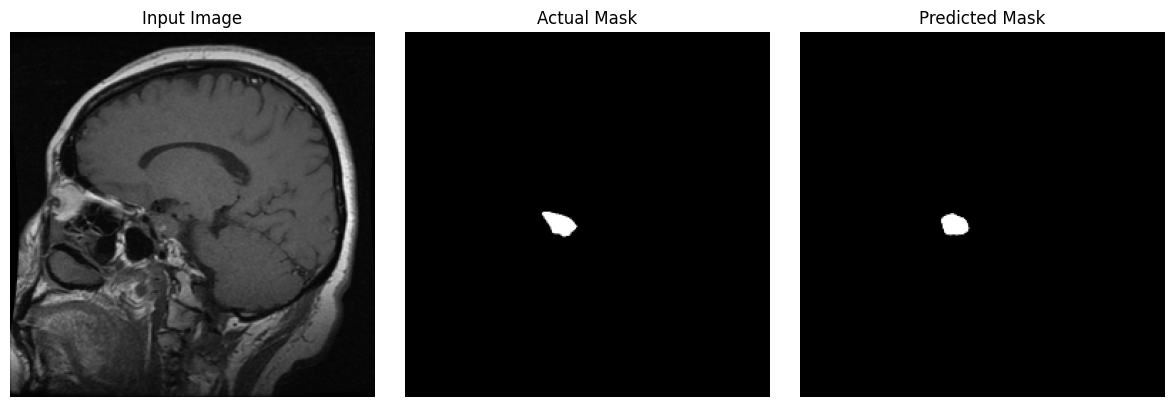

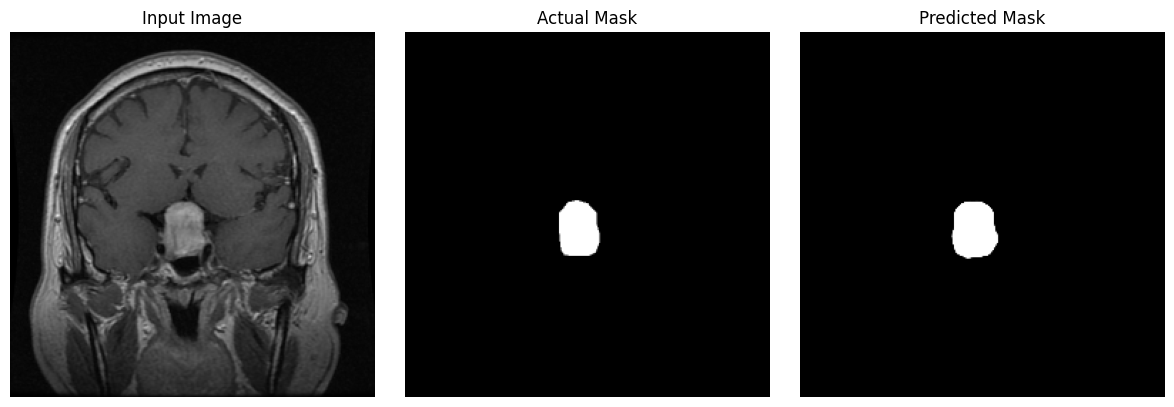

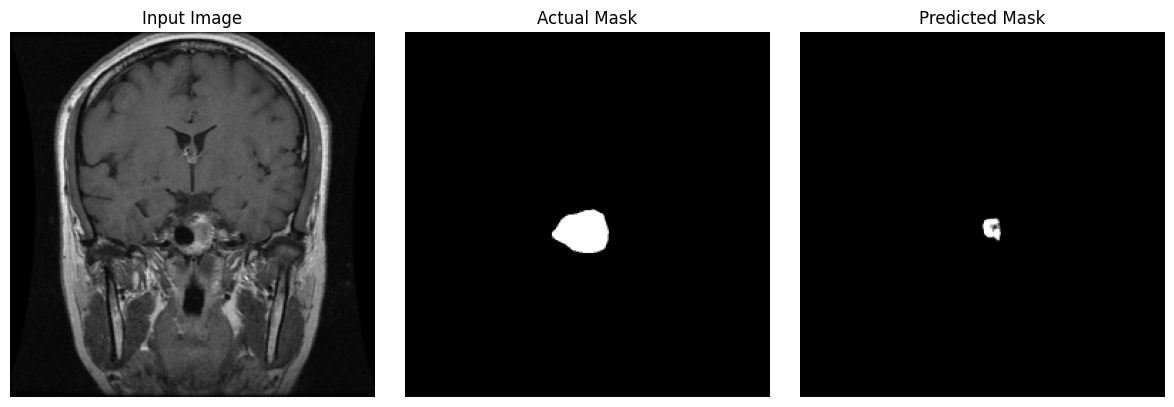

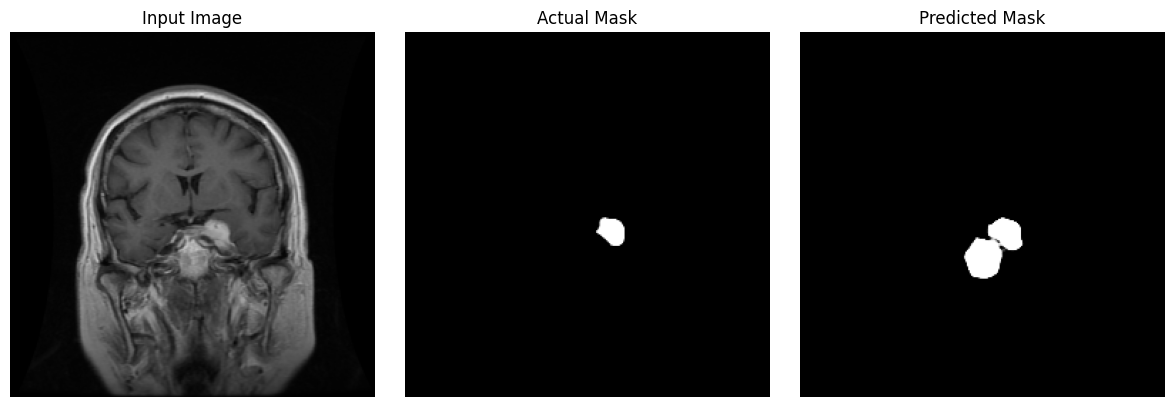

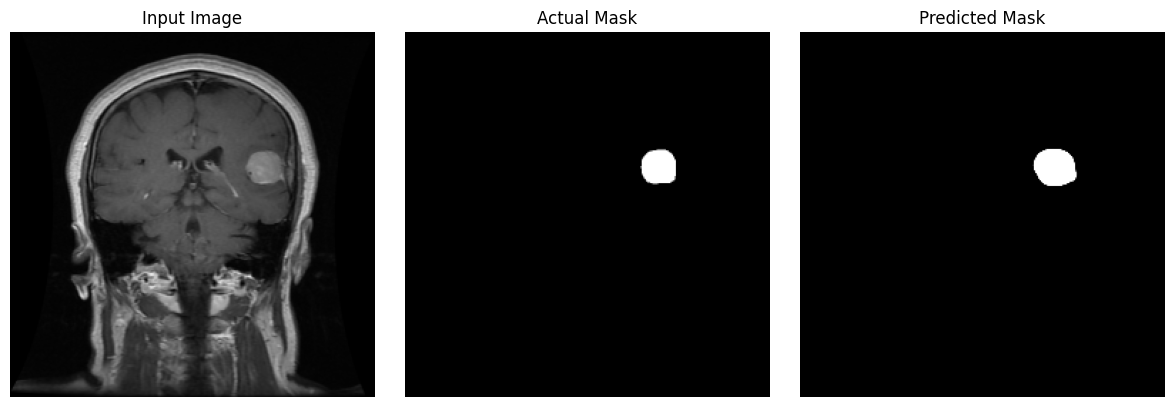

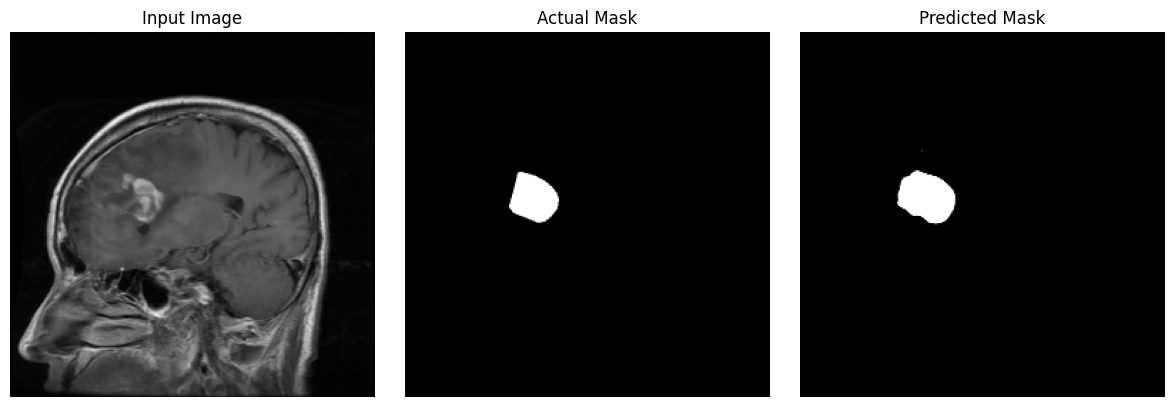

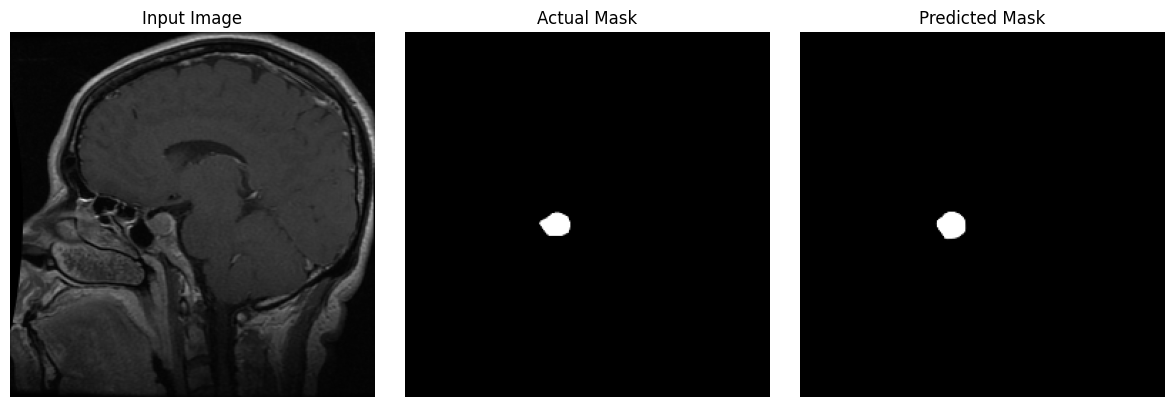

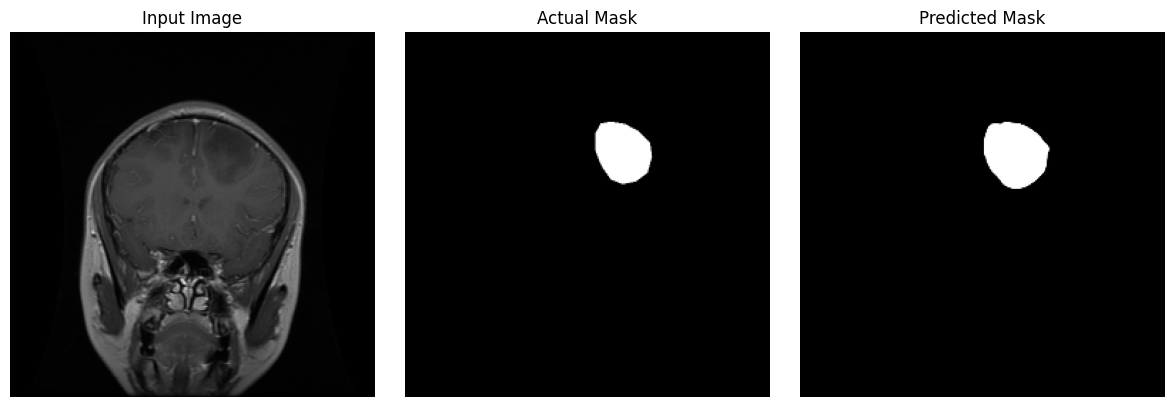

In [16]:
for i, (image, mask) in enumerate(test_dataset_brain.take(1)):
    predicted_mask = basic_unet.predict(image)

    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()